## A SANDBOX TO EXPORT TIFF TO A ZARR, AND ZARR TO A TIFF
### PRACTICE THIS NOTEBOOK ON VIZ2, ABC LAB, UC BERKELEY

In [1]:
import os
import zarr
import numpy as np

In [2]:
# use ~360 MB raw tif files
GPU = 'C:\\Users\\Viz2\\python_anaconda3\\UCB ABC\\demo_napari\\sandbox\\GPU\\raw_tiff'
ZARR = 'C:\\Users\\Viz2\\python_anaconda3\\UCB ABC\\git_clones\\LLS_Pipeline\\Exercises\\Zarr'

# set directory to GPU files 
os.chdir(GPU)
TIFF_PATH = [GPU + '\\' + file for file in os.listdir()]

### Load image data with Dask
REFER TO URL BELOW FOR FULL DOCUMENTATION OF BELOW CODE:<br>
https://blog.dask.org/2019/06/20/load-image-data

In [3]:
# To load a single image, we use Scikit-Image:
import glob
filenames = glob.glob('*.tif')
len(filenames)

# Each filename corresponds to some 3d chunk of a larger image. We can look at a few 2d slices of this single 3d chunk to get some context.

744

In [4]:
# import imageio  # override with dask_image.imread
# sample = imageio.imread(filenames[0])
# sample.shape
# for some reason this is a 2D image

# try this...
dask_filenames = TIFF_PATH[1:] # the reason for [1:] is because of a 'GPU' file in the GPU directory - don't read this!
from dask_image.imread import imread
sample = imread(dask_filenames[0])
sample.shape

(401, 1600, 288)

C:\Users\Viz2\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


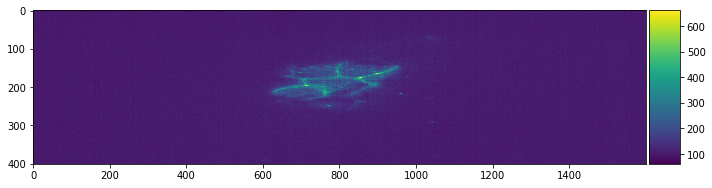

In [82]:
# Each filename corresponds to some 3d chunk of a larger image. We can look at a few 2d slices of this single 3d chunk to get some context.
import matplotlib.pyplot as plt
import skimage.io
plt.figure(figsize=(10, 10))
skimage.io.imshow(sample[:, :, 0])

C:\Users\Viz2\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


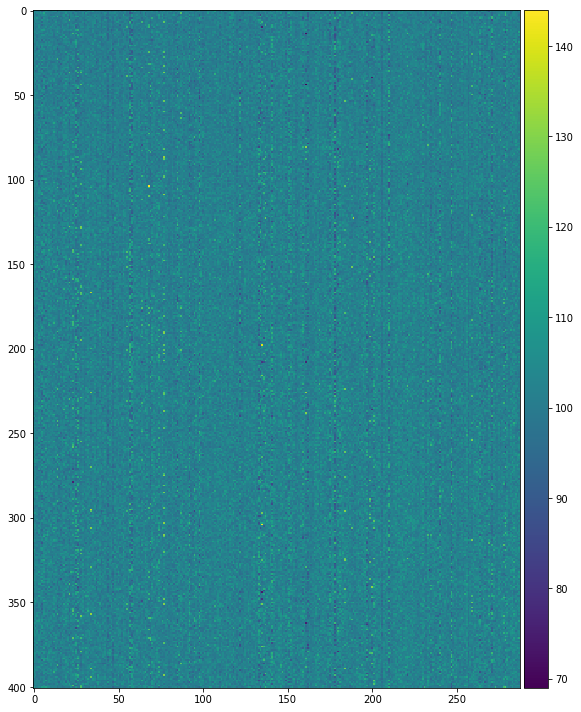

In [38]:
plt.figure(figsize=(10, 10))
skimage.io.imshow(sample[:, 0, :])

C:\Users\Viz2\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


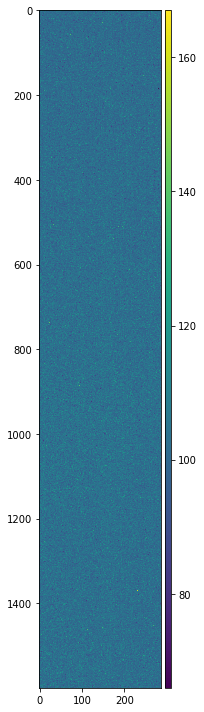

In [39]:
plt.figure(figsize=(10, 10))
skimage.io.imshow(sample[0, :, :])

### Investigate Filename Structures
These are slices from only one chunk of a much larger aggregate image. Our interest here is combining the pieces into a large image stack. It is common to see a naming structure in the filenames. Each filename then may indicate a channel, time step, and spatial location with the <i> being some numeric values (possibly with units). Individual filenames may have more or less information and may notate it differently than we have.<br>
```mydata_ch<i>_<j>t_<k>x_<l>y_<m>z.tif```

In [90]:
# How we might allocate a giant array and then iteratively load images and place them into the giant array.
full_array = np.empty((..., ..., ..., ..., ...), dtype=sample.dtype)

for fn in filenames:
    img = imageio.imread(fn)
    index = get_location_from_filename(fn)  # We need to write this function
    full_array[index, :, :, :] = img

# If our filesize is large, then we can't load it all into memory at once.
# Use Dask, which handles larger-than-memory workloads.

### Lazily load images with Dask Array
Now we learn how to lazily load and stitch together image data with Dask array. We’ll start with simple examples first and then move onto the full example with this more complex dataset afterwards.<br>
We can delay the imageio.imread calls with Dask Delayed.

In [5]:
import dask
import dask.array as da

lazy_arrays = [dask.delayed(imread)(fn) for fn in filenames]
lazy_arrays = [da.from_delayed(x, shape=sample.shape, dtype=sample.dtype)
              for x in lazy_arrays]

Note: here we’re assuming that all of the images have the same shape and dtype as the sample file that we loaded above. This is not always the case. See the dask_image note below in the Future Work section for an alternative.<br>
We haven’t yet stitched these together. We have hundreds of single-chunk Dask arrays, each of which lazily loads a single 3d chunk of data from disk. Lets look at a single array.

In [6]:
lazy_arrays[0]

dask.array<from-value, shape=(401, 1600, 288), dtype=uint16, chunksize=(401, 1600, 288), chunktype=numpy.ndarray>

This is a lazy 3-dimensional Dask array of a single 300MB chunk of data. That chunk is created by loading in a particular TIFF file. Normally Dask arrays are composed of many chunks. We can concatenate many of these single-chunked Dask arrays into a multi-chunked Dask array with functions like da.concatenate and da.stack.<br>
Here we concatenate the first ten Dask arrays along a few axes, to get an easier-to-understand picture of how this looks. Take a look both at how the shape changes as we change the axis= parameter both in the table on the left and the image on the right.

In [7]:
da.concatenate(lazy_arrays[:10], axis=0)

dask.array<concatenate, shape=(4010, 1600, 288), dtype=uint16, chunksize=(401, 1600, 288), chunktype=numpy.ndarray>

In [8]:
da.concatenate(lazy_arrays[:10], axis=1)

dask.array<concatenate, shape=(401, 16000, 288), dtype=uint16, chunksize=(401, 1600, 288), chunktype=numpy.ndarray>

In [9]:
da.concatenate(lazy_arrays[:10], axis=2)

dask.array<concatenate, shape=(401, 1600, 2880), dtype=uint16, chunksize=(401, 1600, 288), chunktype=numpy.ndarray>

Or, if we wanted to make a new dimension, we would use da.stack. In this case note that we’ve run out of easily visible dimensions, so you should take note of the listed shape in the table input on the left more than the picture on the right. Notice that we’ve stacked these 3d images into a 4d image.

In [10]:
da.stack(lazy_arrays[:10])

dask.array<stack, shape=(10, 401, 1600, 288), dtype=uint16, chunksize=(1, 401, 1600, 288), chunktype=numpy.ndarray>

### Full example using scan as the index parameter
This works fine for combining along a single axis. However if we need to combine across multiple we need to perform multiple concatenate steps. Fortunately there is a simpler option da.block, which can concatenate along multiple axes at once if you give it a nested list of dask arrays.<br>
```a = da.block([[laxy_array_00, lazy_array_01],
              [lazy_array_10, lazy_array_11]])```<br><br>
We now do the following:

- Parse each filename to learn where it should live in the larger array
- See how many files are in each of our relevant dimensions
- Allocate a NumPy object-dtype array of the appropriate size, where each element of this array will hold a single-chunk Dask array
- Go through our filenames and insert the proper Dask array into the right position
- Call da.block on the result

This code is a bit complex, but shows what this looks like in a real-world setting

In [11]:
# Get various dimensions
# THIS IS FOR PARSING BY CHANNEL AND STACKS
# e.g. ex6-2_CamA_ch1_CAM1_stack0000_560nm_0000000msec_0001291795msecAbs_000x_000y_000z_0000t.tif

fn_comp_sets = dict()
for fn in filenames:
    for i, comp in enumerate(os.path.splitext(fn)[0].split("_")):
        fn_comp_sets.setdefault(i, set())
        fn_comp_sets[i].add(comp)
fn_comp_sets = list(map(sorted, fn_comp_sets.values()))

remap_comps = [
    dict(map(reversed, enumerate(fn_comp_sets[4]))),  # MUST be the index for channel, e.g. 'ch0'
    dict(map(reversed, enumerate(fn_comp_sets[6])))  # MUST be the index for stack, e.g. 'stack0000'
]

# Create an empty object array to organize each chunk that loads a TIFF
a = np.empty(tuple(map(len, remap_comps)) + (1, 1, 1), dtype=object)

for fn, x in zip(filenames, lazy_arrays):
    channel = int(fn[fn.index("_ch") + 3:].split("_")[0])
    stack = int(fn[fn.index("_stack") + 6:].split("_")[0])

    a[channel, stack, 0, 0, 0] = x

# NOTE: for this example, we only have 2 unique channels and one stack -- find another stacking index
# Stitch together the many blocks into a single array
a = da.block(a.tolist())

In [12]:
a

dask.array<concatenate, shape=(2, 1, 401, 1600, 288), dtype=uint16, chunksize=(1, 1, 401, 1600, 288), chunktype=numpy.ndarray>

### Another example using Scan_Iter as an indexing parameter as opposed to stack

In [13]:
# Get various dimensions
# THIS IS FOR PARSING BY SCAN_ITER AND CHANNELS
# e.g. Scan_Iter_0000_CamA_ch0_CAM1_stack0000_488nm_0000000msec_0016966725msecAbs_000x_000y_000z_0000t.tif

fn_comp_sets = dict()
for fn in filenames:
    for i, comp in enumerate(os.path.splitext(fn)[0].split("_")):
        fn_comp_sets.setdefault(i, set())
        fn_comp_sets[i].add(comp)
fn_comp_sets = list(map(sorted, fn_comp_sets.values()))

remap_comps = [
    dict(map(reversed, enumerate(fn_comp_sets[2]))),  # MUST be the index for scan_iter, e.g. '0003'
    dict(map(reversed, enumerate(fn_comp_sets[4])))  # MUST be the index for channel, e.g. 'ch0'
]

# Create an empty object array to organize each chunk that loads a TIFF
b = np.empty(tuple(map(len, remap_comps)) + (1, 1, 1), dtype=object)

for fn, x in zip(filenames, lazy_arrays):
    scan_iter = int(fn[fn.index("Scan_Iter_") + 10:fn.index("_Cam")].split("_")[0])
    channel = int(fn[fn.index("_ch") + 3:].split("_")[0])

    b[scan_iter, channel, 0, 0, 0] = x
# YOU MUST HAVE SIMILAR CHANNEL TO SCAN_ITER PATTERNS OR ELSE THE PROCESS WILL FAIL
# e.g. every Scan_Iter_ must have 8x ch0 and 4x ch1. Deviate from this pattern will result in an exception!

# Stitch together the many blocks into a single array
b = da.block(b.tolist())

In [26]:
b

,Array,Chunk
Bytes,45.83 GB,369.56 MB
Shape,"(62, 2, 401, 1600, 288)","(1, 1, 401, 1600, 288)"
Count,620 Tasks,124 Chunks
Type,uint16,numpy.ndarray


In [86]:
b.sum().compute()

dask.array<sum-aggregate, shape=(), dtype=uint32, chunksize=(), chunktype=numpy.ndarray>

### Save Data
To simplify data loading in the future, we store this in a large chunked array format like Zarr using the to_zarr method.

In [1]:
# takes eons to complete - look at example below
b.to_zarr("mydata.zarr")

We may add additional information about the image data as attributes. This both makes things simpler for future users (they can read the full dataset with a single line using da.from_zarr) and much more performant because Zarr is an analysis ready format that is efficiently encoded for computation.

Zarr uses the Blosc library for compression by default. For scientific imaging data, we can optionally pass compression options that provide a good compression ratio to speed tradeoff and optimize compression performance.

In [39]:
# single CPU synchronous workflow - slow

from numcodecs import Blosc
b.to_zarr("test_mydata.zarr", compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

# in our case, zarr files are saved in the format "%d.%d.%d.%d.%d", for example "11.1.0.0.0" or "11.0.0.0.0"
# this is likely in the format as "scan_iter.ch.0.0.0"

### Future Work
The workload above is generic and straightforward. It works well in simple cases and also extends well to more complex cases, providing you’re willing to write some for-loops and parsing code around your custom logic. It works on a single small-scale laptop as well as a large HPC or Cloud cluster. If you have a function that turns a filename into a NumPy array, you can generate large lazy Dask array using that function, Dask Delayed and Dask Array.

### Dask Image
However, we can make things a bit easier for users if we specialize a bit. For example the Dask Image library has a parallel image reader function, which automates much of our work above in the simple case.

Similarly libraries like Xarray have readers for other file formats, like GeoTIFF.

As domains do more and more work like what we did above they tend to write down common patterns into domain-specific libraries, which then increases the accessibility and user base of these tools.

In [20]:
# we get an "AttributeError: is_index" when we try to perform this
os.chdir(GPU)

import dask_image
x = dask_image.imread.imread('*.tif')

### GPUs
If we have special hardware lying around like a few GPUs, we can move the data over to it and perform computations with a library like CuPy, which mimics NumPy very closely. Thus benefiting from the same operations listed above, but with the added performance of GPUs behind them.

In [ ]:
import cupy as cp
b_gpu = b.map_blocks(cp.asarray)

### CUDA not found problem on Viz2 -- 2020-02-03
$ pip install cupy

- does not work on Viz2 because "ERROR: CUDA could not be found on your system."
- refer to installation guide here https://docs-cupy.chainer.org/en/stable/install.html
<br>
<br>
************************************************************
* CuPy Configuration Summary                               *
************************************************************

Build Environment:
  Include directories: []
  Library directories: []
  nvcc command       : (not found)

Environment Variables:
  CFLAGS          : (none)
  LDFLAGS         : (none)
  LIBRARY_PATH    : (none)
  CUDA_PATH       : (none)
  NVTOOLSEXT_PATH : (none)
  NVCC            : (none)
  ROCM_HOME       : (none)

Modules:
  cuda      : No
    -> Include files not found: ['cublas_v2.h', 'cuda.h', 'cuda_profiler_api.h', 'cuda_runtime.h', 'cufft.h', 'curand.h', 'cusparse.h', 'nvrtc.h']
    -> Check your CFLAGS environment variable.

ERROR: CUDA could not be found on your system.
Please refer to the Installation Guide for details:
https://docs-cupy.chainer.org/en/stable/install.html

************************************************************

### UPDATE: CUDA 10.1 installed on Viz2 to allow cupy compatibility. Version 10.2 is the latest release, but it is not configured to py libs. -- 2020-02-07

In [15]:
# THIS IS FOR GPU COMPUTATION - START A DASK CLIENT TO VIEW PERFORMANCE

# make sure to pip install dask-cuda prior to import
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
# retrieve client server for viewing
client

C:\Users\Viz2\Anaconda3\lib\site-packages\dask_cuda\utils.py:110: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  % device_index


Client Scheduler: tcp://127.0.0.1:52359 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 548.31 GB


In [31]:
# Try cupy computation using stitched b array.
# perhaps what this is trying to say is that this is synonymous to assigning var 'b' as above.
# b = da.block(b.tolist())
# notice, the chunk type is cupy.ndarray rather than numpy.ndarray

import cupy as cp
b_gpu = b.map_blocks(cp.asarray)
b_gpu

,Array,Chunk
Bytes,45.83 GB,369.56 MB
Shape,"(62, 2, 401, 1600, 288)","(1, 1, 401, 1600, 288)"
Count,744 Tasks,124 Chunks
Type,uint16,cupy.ndarray


In [34]:
# execute code below and you will receive a ValueError:
# ValueError: object __array__ method not producing an array

b_gpu.to_zarr("test_mydata.zarr", compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

ValueError: object __array__ method not producing an array